## Summary

Created: 10/28/2017 (cloned from part2_analysis_wasp21)

Last edit: 10/28

Note:
I initially used the chain produced from previous runs.
I ran a new mcmc because of ff changes:
* impact param is a free parameter instead of inclination
* sampling limb-darkening coeffs in q-space
* simpler systematics model

In [20]:
import datetime as dt

print(dt.datetime.now())

2017-10-28 23:38:28.218195


In [21]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [22]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [23]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
from tqdm import tqdm

In [24]:
#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

## import lc

In [25]:
data_dir='.'

name='hatp44'
date='170215'
target_star_id='2'
comparison_star_id='13'#3
radii_range='9-14'

data={}
bands='g,r,z'.split(',')
sigma=5

for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    #manipulate columns
    cols = df.columns.tolist()
    cols.remove('#')
    cols.insert(-1,' ')
    df.columns = cols
    try:
        df=df.drop(['Unnamed: 21','frame', ' '],axis=1)
    except:
        pass
    df=df.set_index('BJD(TDB)-2450000')
    #df['BJD(TDB)'] = df['BJD(TDB)-2450000'].apply(lambda x: x + 2450000)
    #df=df.set_index('BJD(TDB)')
    #remove outliers
    data[b]=df[np.abs(df-df.mean())<=(sigma*df.std())]

In [26]:
data[b].head()

airmass  sky(ADU)  dx(pix)  dy(pix)  fwhm(pix)  peak(ADU)  \
BJD(TDB)-2450000                                                              
7800.099704        1.9195     769.0    1.571    1.098       9.52     8484.4   
7800.100445        1.9101     759.6    1.183    1.363       9.05     8832.8   
7800.101185        1.9007     758.7    2.001    0.490       8.82     9166.4   
7800.101926        1.8915     757.1    2.197    1.278       8.82     9004.7   
7800.102655        1.8826     753.3    1.232    1.128       8.28     9894.7   

                  flux(r=9.0)  err(r=9.0)  flux(r=10.0)  err(r=10.0)  \
BJD(TDB)-2450000                                                       
7800.099704          1.008784    0.002271      1.005945     0.002288   
7800.100445          1.006547    0.002261      1.005888     0.002283   
7800.101185          1.014396    0.002273      1.012732     0.002296   
7800.101926          1.001108    0.002271      1.000193     0.002290   
7800.102655          1.010541    0.002235      1.009920     0.002263   

                  flux(r=11.0)  err(r=11.0)  flux(r=12.0)  err(r=12.0)  \
BJD(TDB)-2450000                                                         
7800.099704           1.004211     0.002324      1.003111     0.002372   
7800.100445           1.005840     0.002323      1.005248     0.002372   
7800.101185           1.011233     0.002333      1.010332     0.002383   
7800.101926           0.999210     0.002325      0.998171     0.002371   
7800.102655           1.009409     0.002305      1.009090     0.002359   

                  flux(r=13.0)  err(r=13.0)  flux(r=14.0)  err(r=14.0)  
BJD(TDB)-2450000                                                        
7800.099704           1.002090     0.002429      1.002103     0.002496  
7800.100445           1.005178     0.002431      1.003958     0.002494  
7800.101185           1.009567     0.002441      1.008458     0.002506  
7800.101926           0.998673     0.002430      0.999014     0.002494  
7800.102655           1.007839     0.002417      1.007942     0.002484

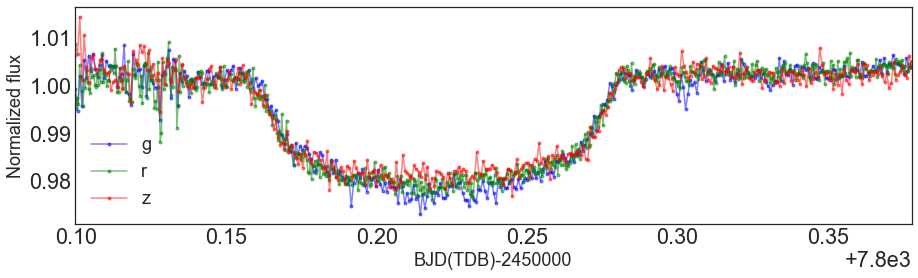

In [27]:
fluxcol='flux(r=9.0)'
sigma = 5
colors='b,g,r'.split(',')

fig,ax = pl.subplots(1,1,figsize=(15,4))
for (b,c) in zip(sorted(bands),colors):
    df = data[b]
    df = df[np.abs(df-df.mean())<=(sigma*df.std())]
    df[fluxcol].plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    ax.set_ylabel('Normalized flux')
pl.legend()

In [28]:
fig.savefig('figs/raw.png')

## building the model

* See [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b) for published transit parameters

In [29]:
from uncertainties import ufloat 

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442) #+0.442-0.226
t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079) #+0.079/-0.074     
a_s = ufloat(11.52,0.74)   
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
#rhop= ufloat()
inc = ufloat(89.10,0.4)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [30]:
_P   = 4.301219
_t14 = 0.1302
_b   = 0.172
_a_s = 11.52
_k   = np.sqrt(0.01804)
_inc = np.deg2rad(89.10)

def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

a_s_=scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

11.809211418629959

In [31]:
inc_ = np.arccos(_b/a_s_)
np.rad2deg(inc_)

89.165463112678623

In [32]:
from pytransit import MandelAgol
MA = MandelAgol()

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    MA = MandelAgol()
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = np.arccos(b/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

In [33]:
tc_0  = 7.8e3+0.22 #2.4578e6+0.22
q1_0, q2_0 = 0.4, 0.4

theta_true= [_k,tc_0,_a_s, _b, q1_0, q2_0]

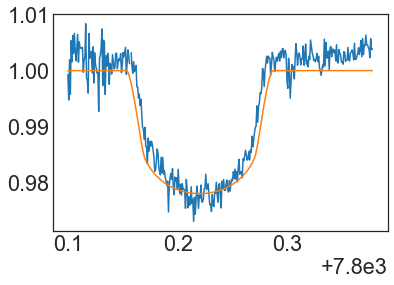

In [34]:
b='g'
f=data[b][fluxcol]
t=data[b].index

m=model_q(theta_true, t, _P)

pl.plot(data[b].index,f)
pl.plot(t,m)

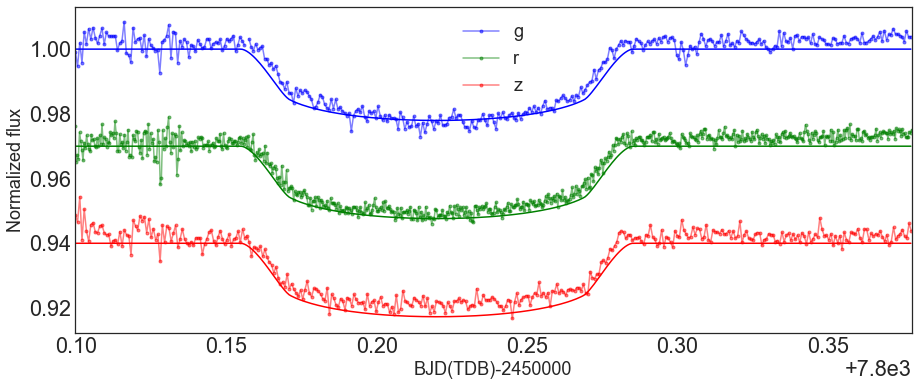

In [35]:
theta_vec = []

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,6))
for i,(b,c) in enumerate(zip(sorted(bands),colors)):
    df = data[b]
    offset = 0.03*i
    df[fluxcol].apply(lambda x: x-offset).plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    #compute model
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    m=model_q(theta, t, _P)
    ax.plot(t,m-offset,color=c)
    ax.set_ylabel('Normalized flux')
    theta_vec.append(theta)
pl.legend()

In [36]:
import scipy.optimize as op

def obj(theta, t, f, p):
    '''
    objective function is ordinary least squares
    c.f. chi-quared which includes point-wise sigma
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

In [37]:
ts = [data[b].index for b in sorted(bands)]
fluxes = [data[b][fluxcol] for b in bands]

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [38]:
import scipy.optimize as op

def obj(theta, t, f, p):
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

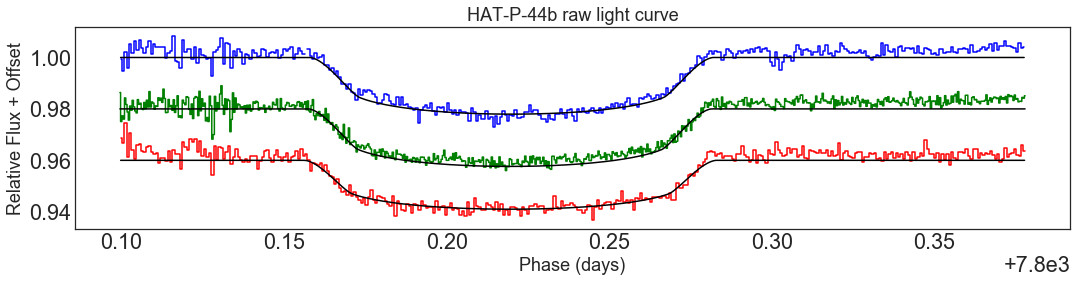

In [39]:
fontsize=18

ts,fluxes=[],[]
airmasses,uncs,dxs,dys=[],[],[],[]

colors='b,g,r'.split(',')

fig, axs = pl.subplots(1,1, figsize=(15,4), sharey=True)
for i,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)    
    f=d[fluxcol]
    t=f.index
    
    ts.append(t)
    fluxes.append(f)
    
    axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    res = op.minimize(obj, theta_vec[i], args=(t, f, _P), method='nelder-mead')
    model = model_q(res.x, t, _P)
    axs.plot(t, model-0.02*i, 'k-');
    
    fig.tight_layout()

    
    #sys mod params
    airmasses.append(d['airmass'].values)
    uncs.append(d['err(r=11.0)'].values)
    #peak_fluxes.append(d['peak'].values)
    #fwhms.append(d['fwhm'].values)
    dxs.append(d['dx(pix)'].values)
    dys.append(d['dy(pix)'].values)
    
axs.set_title('HAT-P-44b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [40]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, aux_vec, ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[7:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -1691.1095804297552
NLL after: -2053.7743874117778
residual: std=0.0025, rms=0.0025
--r--
NLL before: -3202.3810095464924
NLL after: -3867.077327100783
residual: std=0.0022, rms=0.0024
--z--
NLL before: -1721.055760539868
NLL after: -2047.5233273617778
residual: std=0.0023, rms=0.0026


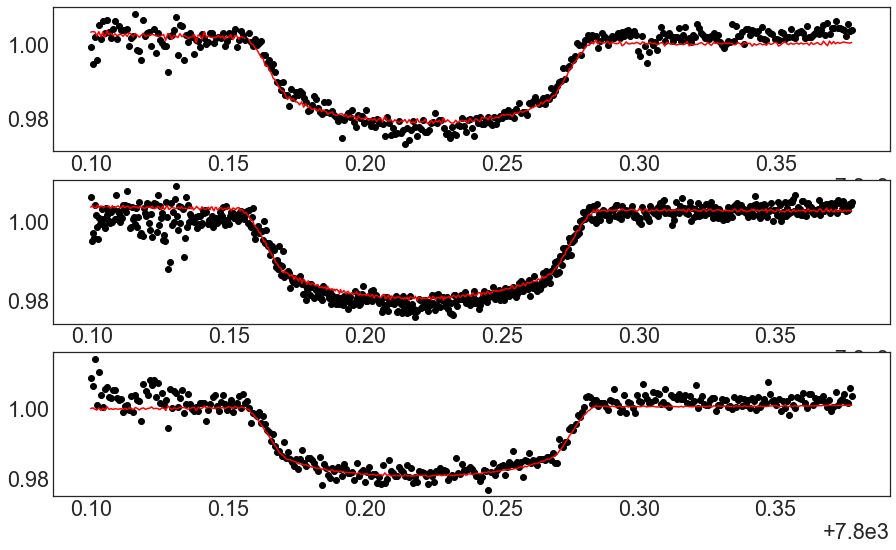

In [42]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
nparams=5
ip = 0 #impact param, b
#parameters vector: 6 free, 7 input

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)
    #remove outliers
    #d=d[np.abs(d-d.mean())<=(3*d.std())]

    f=d[fluxcol]
    t=f.index

    #sys mod params
    airmass = d['airmass'].values
    err=d['err(r=11.0)'].values
    #peak_flux=d['peak(ADU)'].values
    #fwhm = d['fwhm(pix)'].values
    dx = d['dx(pix)'].values
    dy = d['dy(pix)'].values
    fwhm = d['fwhm(pix)'].values
    sky = d['sky(ADU)'].values
    peak = d['peak(ADU)'].values
    print('--{}--'.format(b))
    
    #parameters vector: 6 free, 3 input
    ls = np.log(np.nanstd(f))
    
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta_sys = np.concatenate((theta, [ls], k_list[:nparams]))
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_sys, t, f, _P, aux_vec)))
    result = op.minimize(nll, theta_sys,    args=(t, f, _P, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,   t, f, _P, aux_vec)))

    f_pred = loglike(result.x, t, f, _P, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, _P, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, _P, aux_vec, ret_sys=True)
    resid=f-f_pred
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = pl.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

In [43]:
fig.savefig('figs/model-MLE.png')

## Limb-darkening prior
```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [44]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [45]:
theta

[0.13631306712304653, 7800.22, 11.830522779350026, 0.172, 0.4, 0.4]

In [46]:
from scipy import stats
def logprior(theta,up=None):
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > 1 or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a   < 0 or a  > 100 or \
        tc < t[0] or tc > t[-1]:
            
        #print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,impact_param,q12,q22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,impact_param,q13,q23,ls3,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, aux_vec1)
    ll += loglike(theta2, t2, f2, p, aux_vec2)
    ll += loglike(theta3, t3, f3, p, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [47]:
theta_vec=[]
for i,j in enumerate(bands):
    #a.append(scaled_a(p_, t14_, k_, inc=np.pi/2))
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta.append(theta_vec)

k1,k2,k3     = [_k+0.001,_k+0.002,_k+0.003]  
q11,q12, q13 = [0.4] * 3
q21,q22, q23 = [0.4] * 3
a1,a2,a3     = [a_s_]* 3

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

In [48]:
theta_sys = [k1,k2,k3,tc_0,a1,a2,a3,_b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,airmasses,dxs,dys]

In [49]:
#without ldp
logprob(theta_sys, *args)

6613.3217020702277

In [50]:
#with ldp
logprob(theta_sys, *args, up=ldp)

6572.2154660287806

## Run mcmc

## Initial results: Parameter best estimates (including burn-in)

In [10]:
#new results
import gzip
loc='.'

with gzip.GzipFile(os.path.join(loc,'chain1.npy.gz'), "r") as g:
    chain=np.load(g)
chain.shape

(256, 1000, 32)

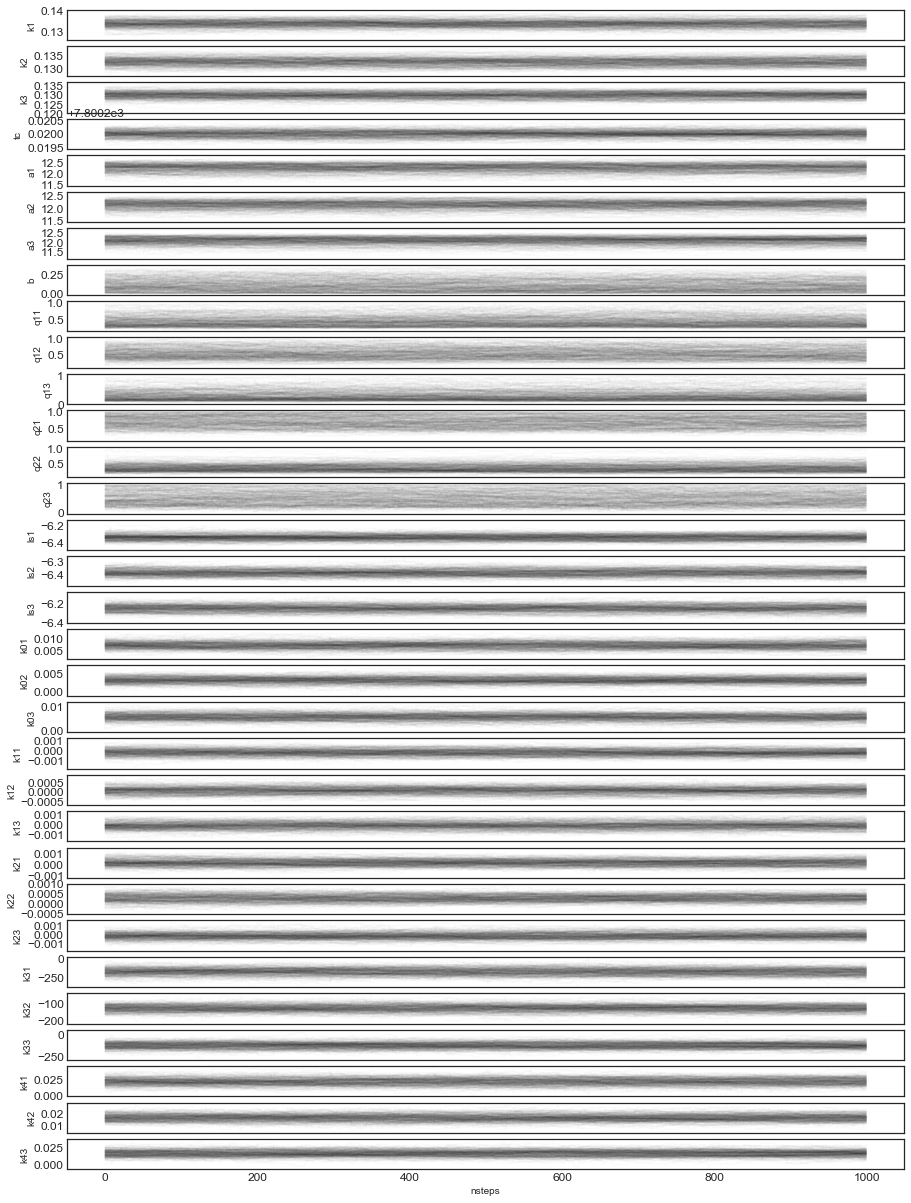

In [11]:
pl.style.use('seaborn-white')
%matplotlib inline
param_names='k1,k2,k3,tc,a1,a2,a3,b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')
    
nwalkers, nsteps, ndim = chain.shape
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
#ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
#percs = [np.percentile(sampler.chain2[:,:,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
#[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

In [12]:
burn=500
fc = chain[:,burn:,:].reshape([-1,chain.shape[-1]])
fc.shape

(128000, 32)

## Recalculate logprob

In [ ]:
fc_lnprob=[logprob(th, *args) for th in tqdm(fc)]

In [52]:
lnprob=np.array(fc_lnprob)

In [59]:
#load
with gzip.GzipFile(os.path.join(loc,'lnprob1.npy.gz'), "r") as g:
    lnp=g.read()
    #lnp=np.load(g)
np.array(lnp).shape

()

## excluding burn-in

In [40]:
fig.savefig('figs/chain2.png')

In [32]:
burn=500
fc = chain2[:,burn:,:].reshape([-1,chain2.shape[-1]])
fc.shape

(128000, 32)

In [34]:
del chain2

In [33]:
fc_lnprob=[logprob(th, *args) for th in tqdm(fc)]

100%|██████████| 128000/128000 [1:04:12<00:00, 33.22it/s]


In [35]:
lnp2=np.array(fc_lnprob)
lnp2.shape

(128000,)

In [77]:
with gzip.GzipFile('lnprob.npy.gz', 'r') as g:
    g.read(lnp2)

## Results

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

In [61]:
#using full chain excluding burn-in
max_idx=np.argmax(lnp2) #fc_lnprob

#posterior of parameter vector
pv=fc[max_idx,:]

for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k1: 0.1334
k2: 0.1341
k3: 0.1310
tc: 7800.2202
a1: 12.1758
a2: 12.0250
a3: 11.9962
b: 0.2243
q11: 0.3051
q12: 0.3580
q13: 0.1809
q21: 0.8947
q22: 0.5255
q23: 0.6127
ls1: -6.3014
ls2: -6.3262
ls3: -6.1867
k01: 0.0104
k02: 0.0019
k03: 0.0061
k11: -0.0001
k12: 0.0001
k13: -0.0001
k21: 0.0010
k22: 0.0001
k23: 0.0000
k31: -270.1595
k32: -107.2007
k33: -130.6789
k41: 0.0346
k42: 0.0137
k43: 0.0168


In [62]:
final_theta=np.copy(pv)

In [63]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

k1           k2           k3           tc           a1  \
count  128000.0000  128000.0000  128000.0000  128000.0000  128000.0000   
mean        0.1335       0.1325       0.1298    7800.2200      12.2397   
std         0.0019       0.0015       0.0018       0.0001       0.1916   
min         0.1263       0.1274       0.1236    7800.2195      11.4825   
25%         0.1323       0.1314       0.1285    7800.2199      12.1121   
50%         0.1335       0.1324       0.1299    7800.2200      12.2594   
75%         0.1347       0.1335       0.1311    7800.2201      12.3773   
max         0.1398       0.1380       0.1355    7800.2205      12.7608   

                a2           a3           b          q11          q12  \
count  128000.0000  128000.0000  1.2800e+05  128000.0000  128000.0000   
mean       12.1389      12.0722  1.1419e-01       0.4346       0.5366   
std         0.1610       0.1931  7.8641e-02       0.1632       0.1857   
min        11.4984      11.1928  7.9139e-06       0.1734       0.1137   
25%        12.0421      11.9519  4.7734e-02       0.3039       0.3926   
50%        12.1532      12.1008  1.0070e-01       0.3960       0.5156   
75%        12.2549      12.2064  1.7279e-01       0.5336       0.6698   
max        12.6085      12.6657  3.6496e-01       0.9975       0.9989   

          ...               k13         k21          k22         k23  \
count     ...       128000.0000  1.2800e+05  128000.0000  1.2800e+05   
mean      ...           -0.0001  1.7817e-04       0.0003 -1.4825e-04   
std       ...            0.0004  3.0546e-04       0.0002  3.6837e-04   
min       ...           -0.0014 -9.8062e-04      -0.0004 -1.3559e-03   
25%       ...           -0.0004 -4.3643e-05       0.0001 -4.0660e-04   
50%       ...           -0.0001  1.8135e-04       0.0003 -1.7365e-04   
75%       ...            0.0001  3.8456e-04       0.0004  9.0137e-05   
max       ...            0.0012  1.4524e-03       0.0009  1.2248e-03   

               k31          k32          k33          k41          k42  \
count  128000.0000  128000.0000  128000.0000  128000.0000  128000.0000   
mean     -172.9960    -127.4637    -127.1194       0.0222       0.0163   
std        46.2090      21.2261      35.5128       0.0059       0.0027   
min      -355.1016    -214.2737    -264.7786       0.0020       0.0055   
25%      -206.3326    -141.7639    -151.7113       0.0181       0.0145   
50%      -172.5840    -126.6643    -128.4153       0.0221       0.0162   
75%      -140.9312    -112.8616    -101.6319       0.0265       0.0182   
max       -15.4650     -42.6701      39.6052       0.0455       0.0275   

               k43  
count  128000.0000  
mean        0.0163  
std         0.0046  
min        -0.0051  
25%         0.0130  
50%         0.0165  
75%         0.0194  
max         0.0339  

[8 rows x 32 columns]

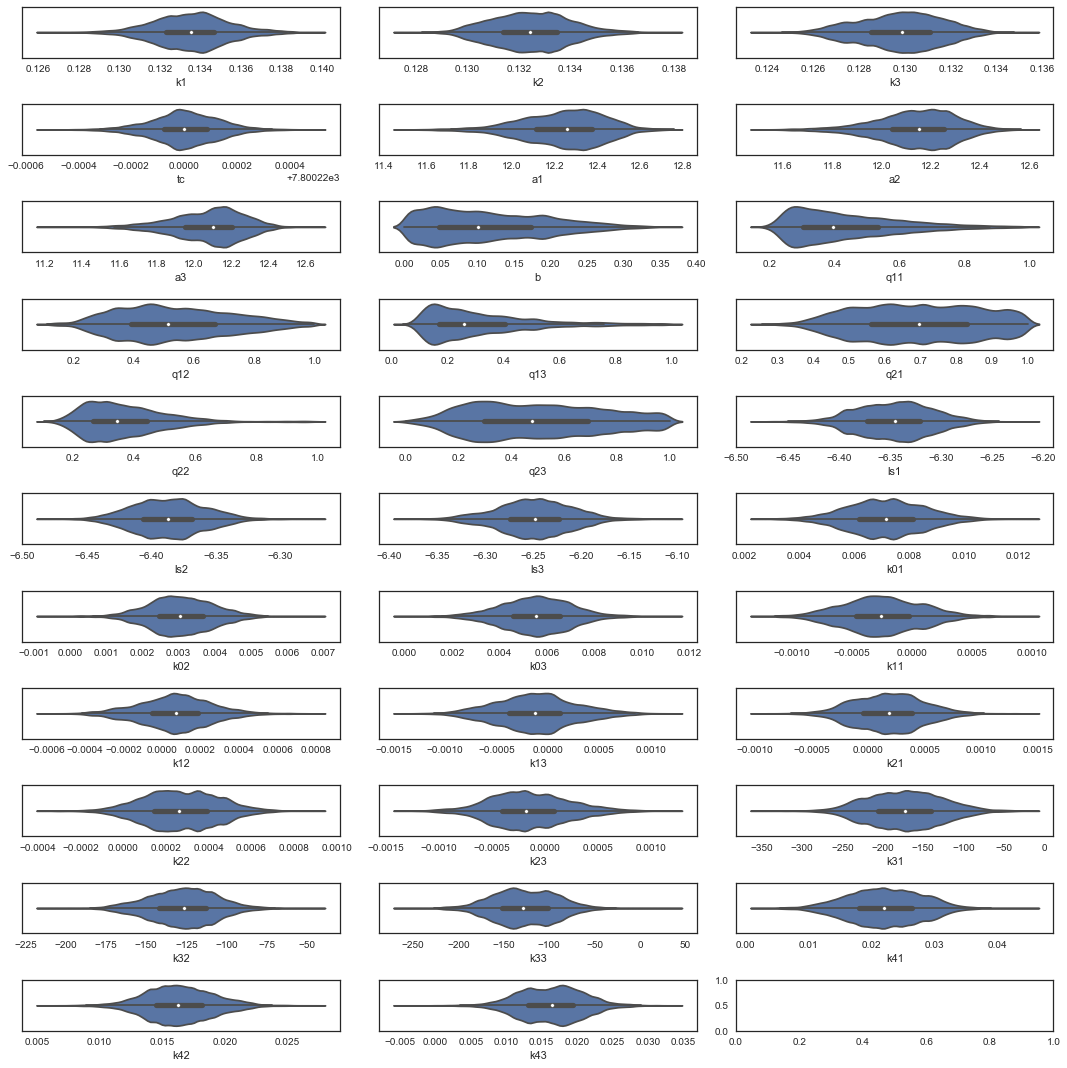

In [64]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = pl.subplots(11,3, figsize=(15,15))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    pl.setp(axs, ylabel='')
    fig.tight_layout()

In [65]:
fig.savefig('figs/params_aposteriori_distributions.png')

## BIC

In [46]:
def compute_bic(n,k,logL):
    '''
    n: number of data points
    m: number of parameters
    L: the maximized value of the likelihood function of the model
    '''
    return np.log(n)*m-2*logL

## Sample the flatchain

In [66]:
#100 samples from the posterior for each band 
mod_sys={}
sys={}
mod={}

# theta1 = [k1,tc,a1,inc,u11,u21,ls1,k01,k11,k21,k31,k41]
# theta2 = [k2,tc,a2,inc,u12,u22,ls2,k02,k12,k22,k32,k42]
# theta3 = [k3,tc,a3,inc,u13,u23,ls3,k03,k13,k23,k33,k43]

col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

In [67]:
[param_names[i] for i in col1]

['k1', 'tc', 'a1', 'b', 'q11', 'q21', 'ls1', 'k01', 'k11', 'k21', 'k31', 'k41']

$$
\rm \frac{no \; detection - expected \; value}{1\sigma \; bin} = 2.4 \; \sigma
$$

$$
P(\theta|D)\propto P(\theta) \times P(D|\theta) 
$$

In [68]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

#params varies per band
for b,t,f,am,xc,yc,col in zip(bands,
                             [t1,t2,t3],
                             [f1,f2,f3],
                             [airmass1,airmass2,airmass3],
                             #[unc1,unc2,unc3],
                             [xcen1,xcen2,xcen3],
                             [ycen1,ycen2,ycen3],
                            [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    
    aux_vec = [am, xc, yc]
    
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        #get proper columns for theta
        for c in col:
            cc.append(th[c])
            #theta = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
        mod_sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_full=True))
        sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_sys=True))
        mod[b].append(loglike(cc, t, f, _P, aux_vec, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, t, f, _P, aux_vec, ret_mod=True)
    sys_best[b] = loglike(vv, t, f, _P, aux_vec, ret_sys=True)
    full_best[b] = loglike(vv, t, f, _P, aux_vec, ret_full=True)

check mean distribution for n samples sampled m times

### transit model

In [69]:
pv[3]

7800.2201826782566

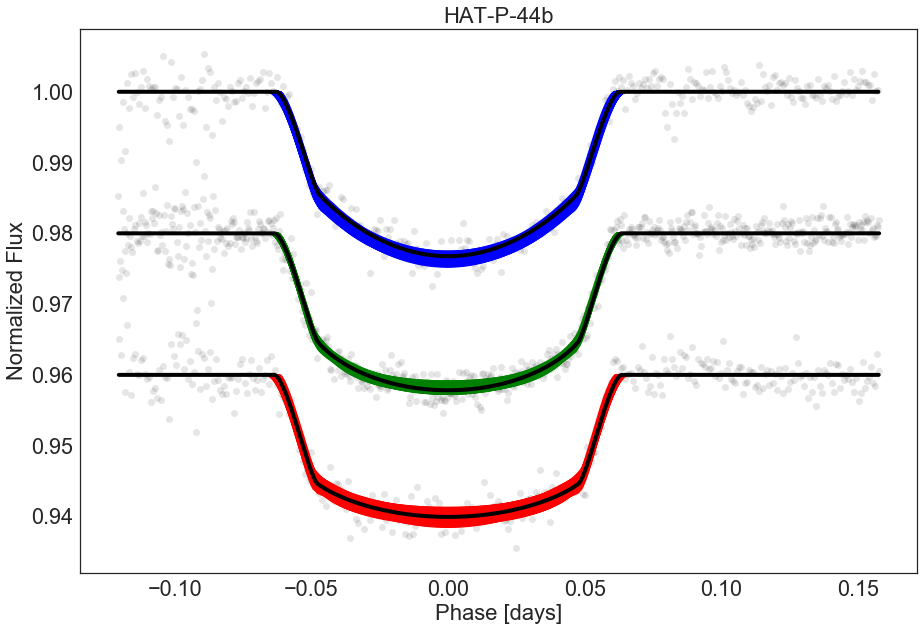

In [70]:
pl.style.use('seaborn-white')
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22

labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=pl.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(ts[n]-tc_hat, fluxes[n]-sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(ts[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('HAT-P-44b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

In [71]:
pl.savefig('figs/1000_posterior_samples.png')

### systematics model

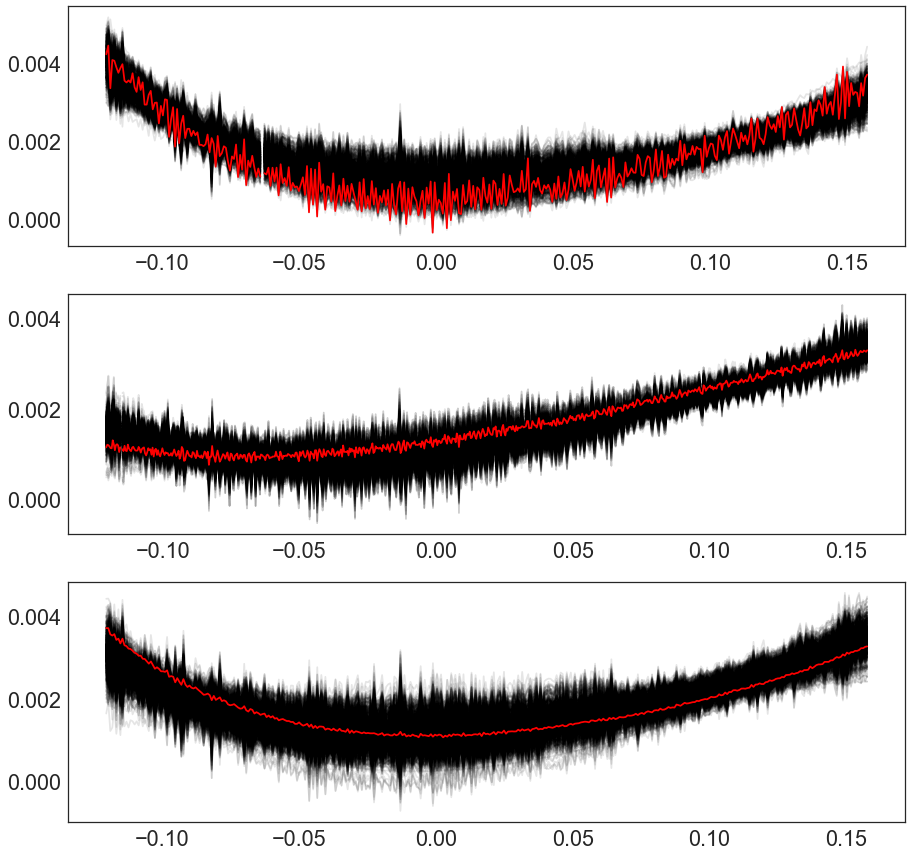

In [72]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-',alpha=0.1)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, sys_best[b], 'r-')

In [73]:
pl.savefig('figs/sys.png')

### systematics + transit

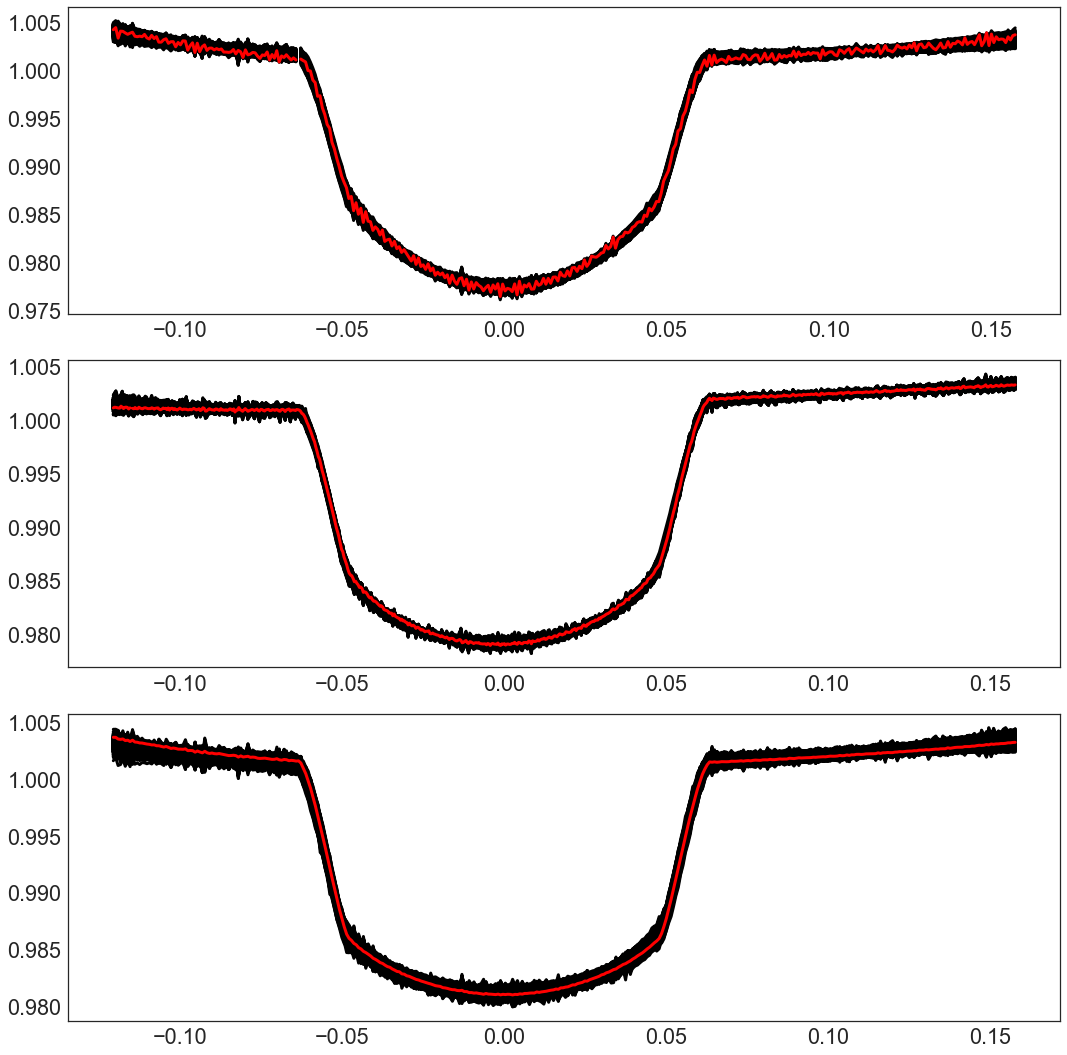

In [78]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in mod_sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-')
    #superpose best fit
    ax.plot(ts[n]-tc_hat, full_best[b], 'r-')
pl.tight_layout()

In [80]:
pl.savefig('figs/transit with sys.png',bbox_inches='tight',pad_inches=0.01)

## g-band

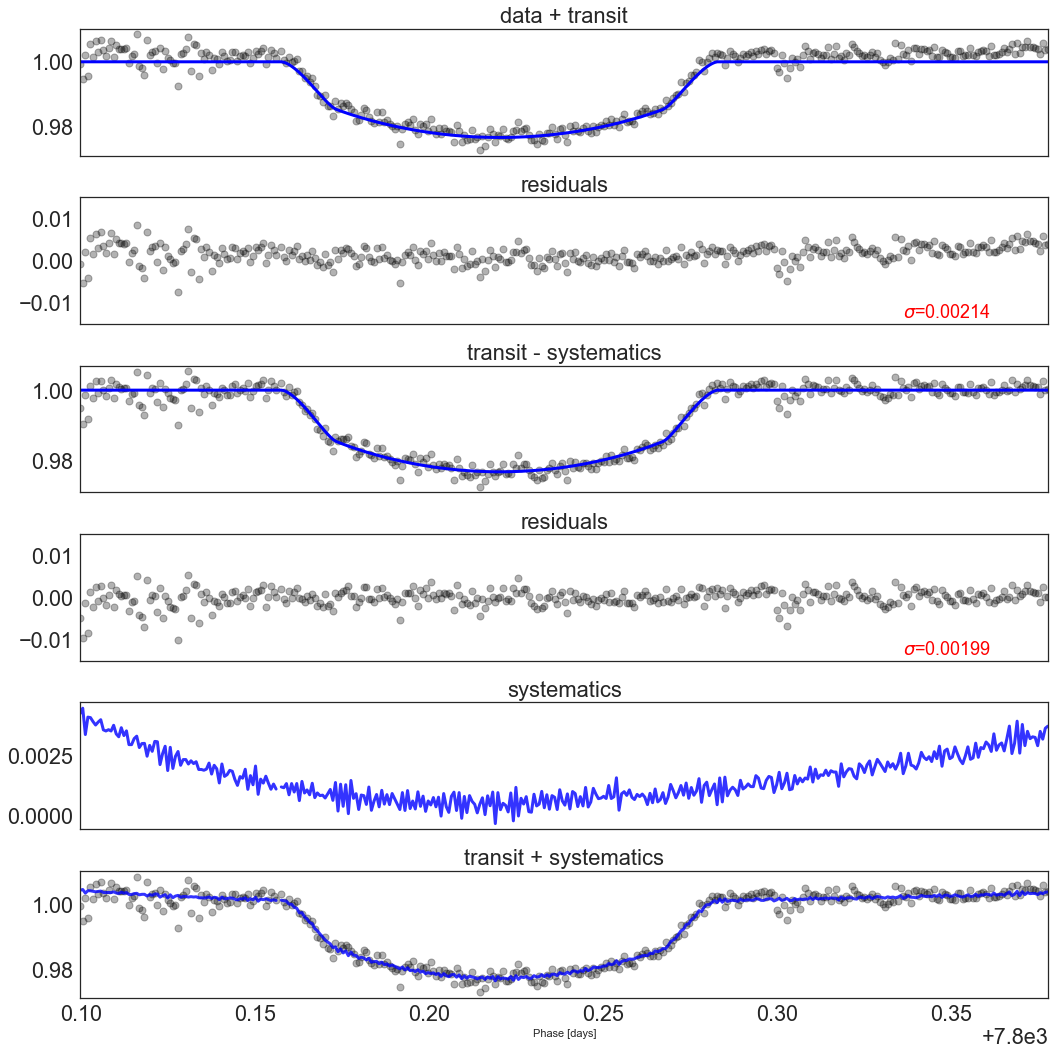

In [76]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
pl.rcParams['lines.linewidth'] = 3
n=0
b='g'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'b-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'b-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'b-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'b-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [77]:
pl.savefig('figs/summary_g.png')

## r-band

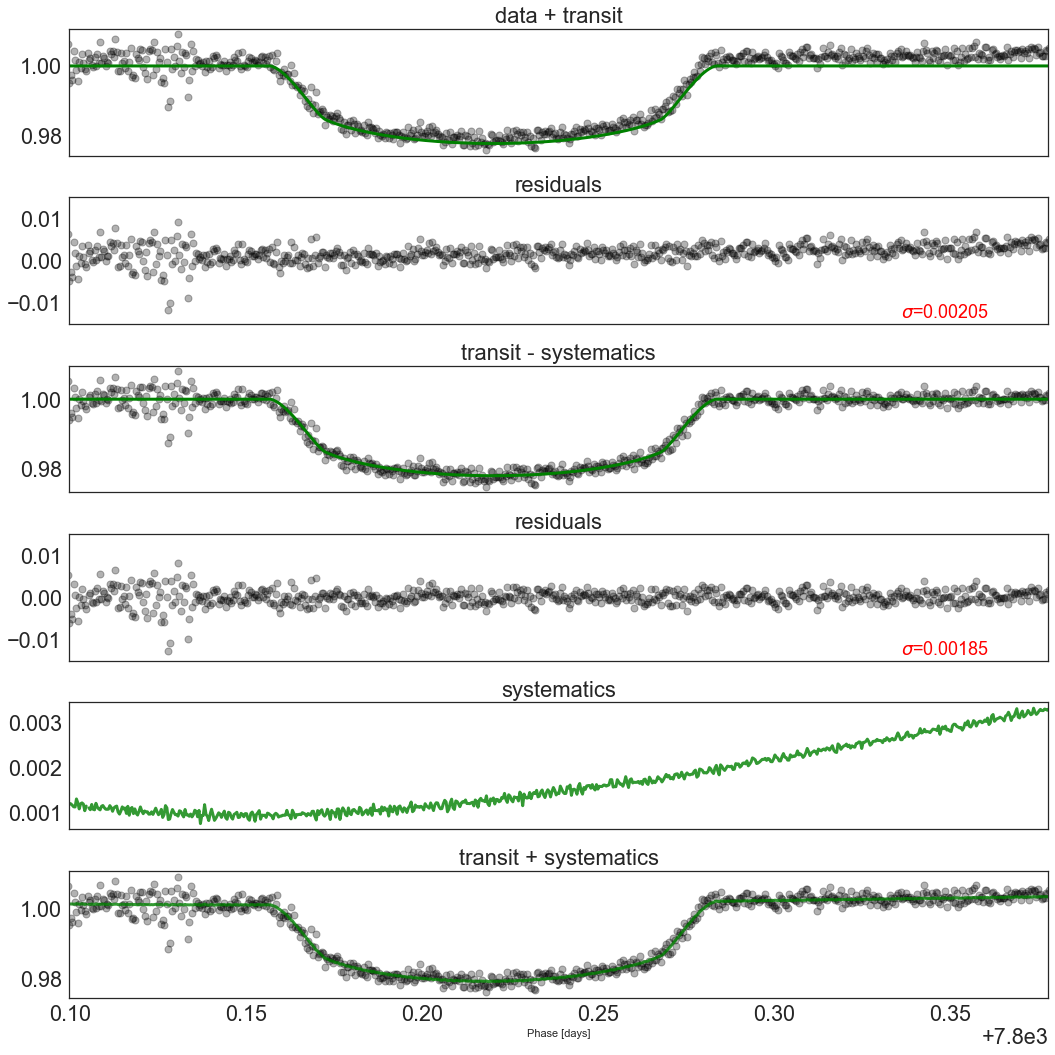

In [81]:
n=1
b='r'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'g-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'g-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'g-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'g-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [82]:
pl.savefig('figs/summary_r.png')

## z-band

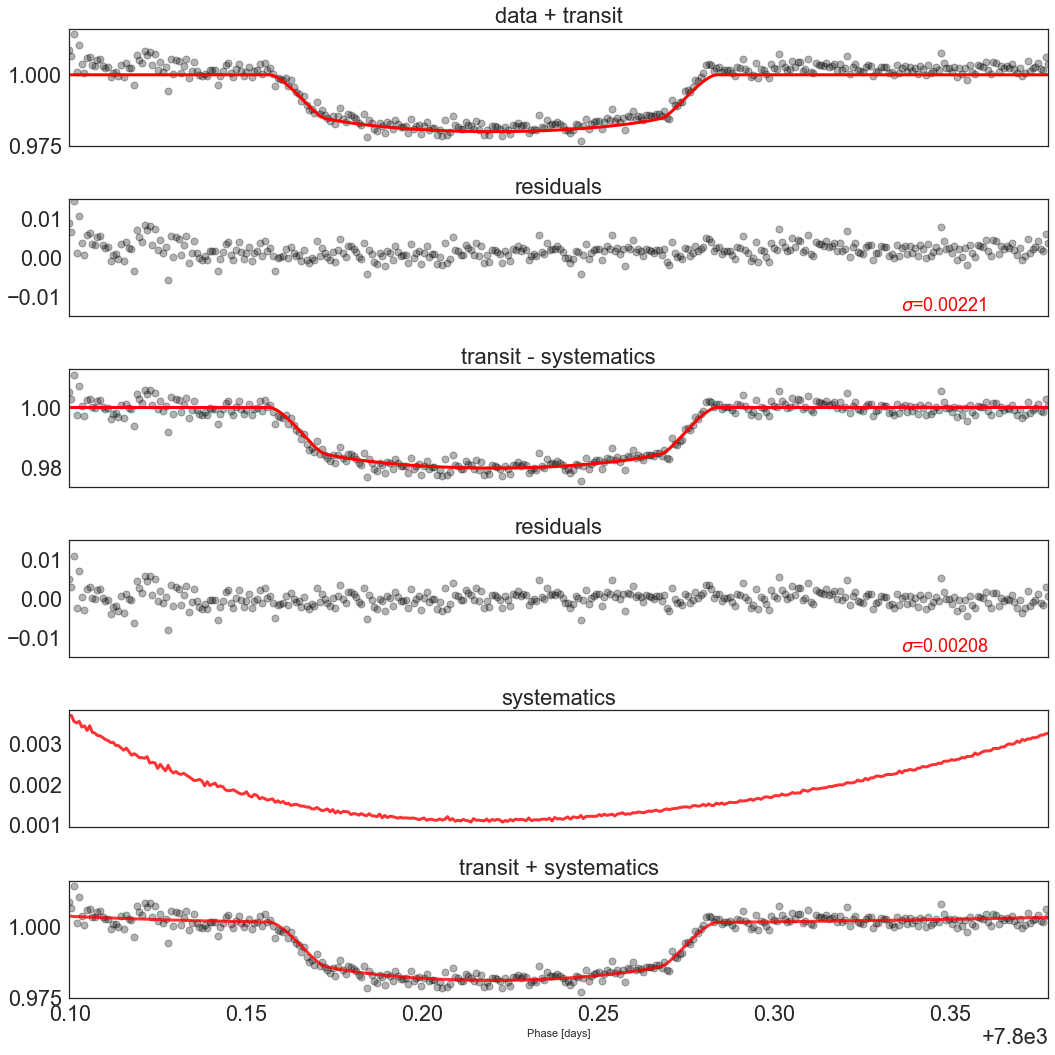

In [83]:
n=2
b='z'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'r-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'r-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [84]:
pl.savefig('figs/summary_z.png')

## rms of residuals

In [85]:
def rms(x):
    return np.sqrt(np.nanmean(x**2))

In [86]:
thinning=10
for n,b in enumerate(bands):
    print(b)
    print('rms={}'.format(rms(fluxes[n]-sys_best[b]-mod_best[b])*100))

g
rms=0.19859754833670856
r
rms=0.18552042927655546
z
rms=0.20757315615357125


## binning
* See [stackoverflow](https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy)

The binning must be less than t14 and/or t34. Based on the best fit model on the detrended light curve, t14 is about 0.01 to 0.02 day.

## binning before model fitting

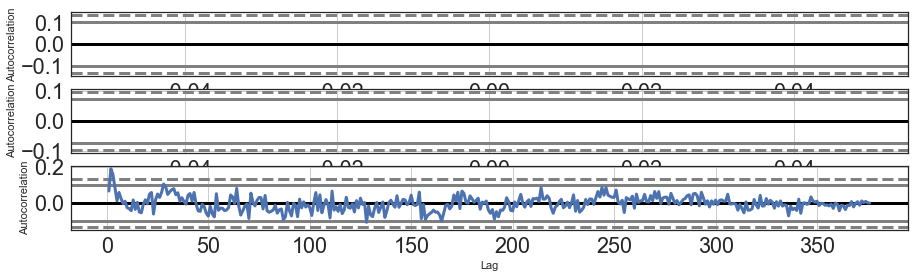

In [87]:
from pandas.plotting import autocorrelation_plot

fig = pl.figure(figsize=(15,4))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    autocorrelation_plot(fluxes[n]-sys_best[b]-mod_best[b], ax=ax)
    #autocorrelation_plot(sys_best[b]-mod_best[b], ax=ax)

In [83]:
fig.savefig('figs/autocorr.png')

correlation: u1, u2; k1, k3; i, a

In [88]:
n,b=0,'g'

d1 = {'g_flux': fluxes[n], 'g_mod': mod_best[b], 'g_sys':sys_best[b], 'g_full': full_best[b], 'g(f-sys)': fluxes[n]-sys_best[b]}
df1=pd.DataFrame(data=d1, index=ts[n])

n,b=1,'r'
d2 = {'r_flux': fluxes[n], 'r_mod': mod_best[b], 'r_sys':sys_best[b], 'r_full': full_best[b], 'r(f-sys)': fluxes[n]-sys_best[b]}
df2=pd.DataFrame(data=d2, index=ts[n])


n,b=2,'z'
d3 = {'z_flux': fluxes[n], 'z_mod': mod_best[b], 'z_sys':sys_best[b], 'z_full': full_best[b], 'z(f-sys)': fluxes[n]-sys_best[b]}
df3=pd.DataFrame(data=d3, index=ts[n])

frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

g(f-sys)  g_flux  g_full  g_mod  g_sys  r(f-sys)  r_flux  \
BJD(TDB)-2450000                                                             
7800.3748              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3756              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3763              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3771              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3778              NaN     NaN     NaN    NaN    NaN       NaN     NaN   

                  r_full  r_mod  r_sys  z(f-sys)  z_flux  z_full  z_mod  \
BJD(TDB)-2450000                                                          
7800.3748            NaN    NaN    NaN    1.0011  1.0042  1.0032    1.0   
7800.3756            NaN    NaN    NaN    0.9989  1.0021  1.0032    1.0   
7800.3763            NaN    NaN    NaN    0.9984  1.0016  1.0032    1.0   
7800.3771            NaN    NaN    NaN    1.0029  1.0061  1.0033    1.0   
7800.3778            NaN    NaN    NaN    1.0005  1.0038  1.0033    1.0   

                   z_sys  
BJD(TDB)-2450000          
7800.3748         0.0032  
7800.3756         0.0032  
7800.3763         0.0032  
7800.3771         0.0033  
7800.3778         0.0033

## Save

In [90]:
final_df.to_csv('after_mcmc_hatp44b.csv')

In [91]:
np.save('theta_post.csv',final_theta)

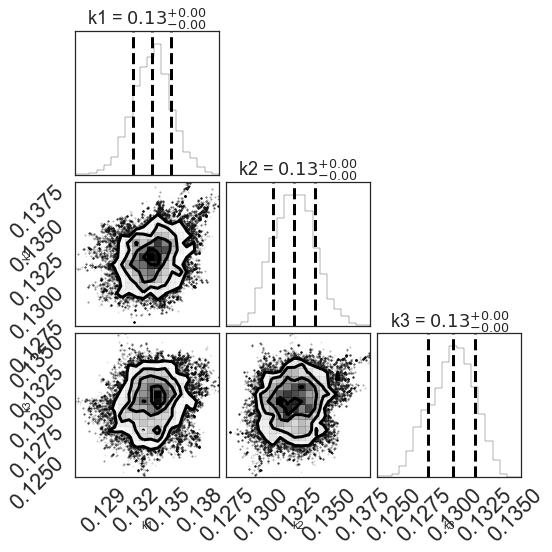

In [92]:
import corner


fig =  corner.corner(fc[:,:3], labels=param_names[:3], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [93]:
fig.savefig('figs/joint_k.png')

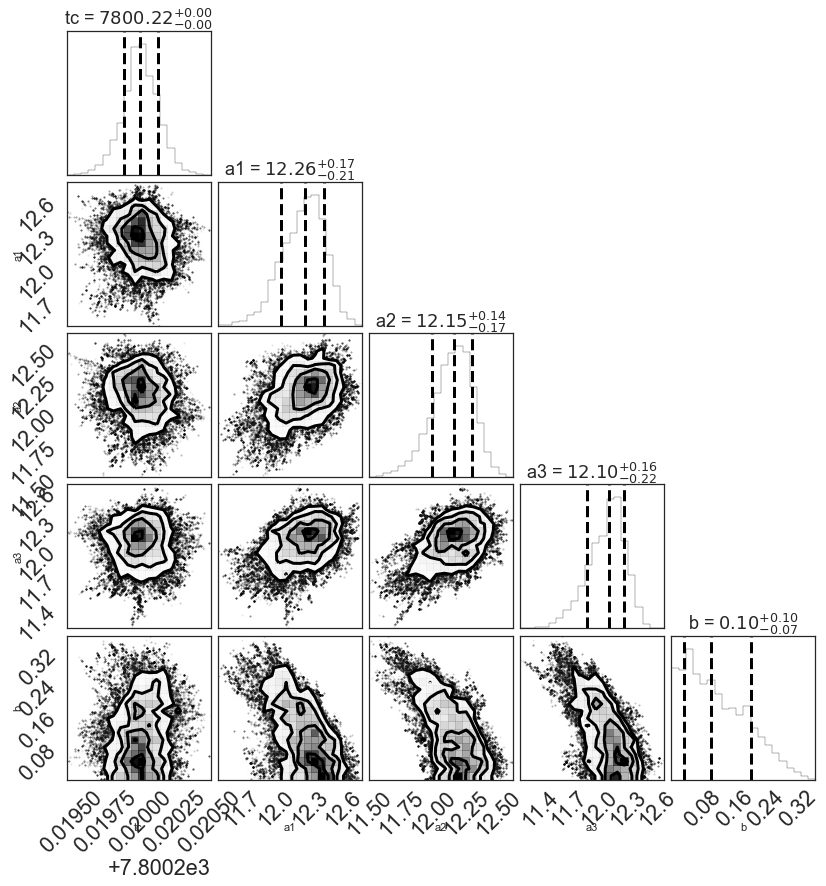

In [94]:
import corner

fig = corner.corner(fc[:,3:8], labels=param_names[3:8], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [95]:
fig.savefig('figs/joint_tc_a_b.png')

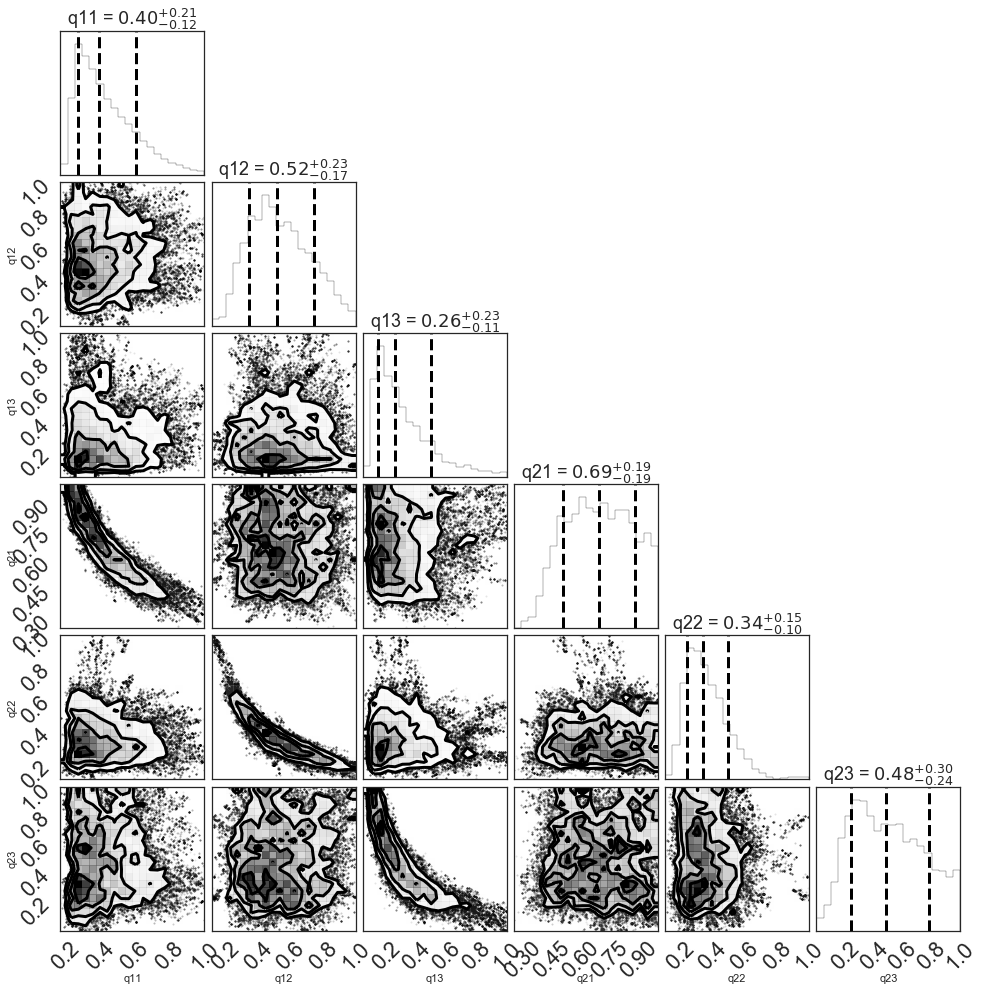

In [96]:
fig = corner.corner(fc[:,8:14], labels=param_names[8:14], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [98]:
fig.savefig('figs/limbdar_q1q2.png')

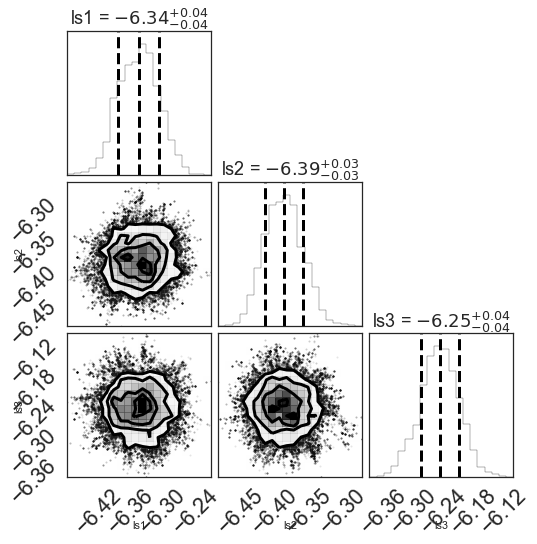

In [99]:
fig = corner.corner(fc[:,14:17], labels=param_names[14:17], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [100]:
fig.savefig('figs/logsigma.png')

In [101]:
fig = corner.corner(fc[:,17:], labels=param_names[17:], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [102]:
fig.savefig('figs/joint_coeffs.png')

## even sampling of time (index)

Add evenly sampled time to compensate for sparse data (resulting to edgy/not smooth model fits especially in limb-darkening areas.

### Reevaluate model using new evenly-sampled time

## best fit with uncertainties: credible intervals

In [103]:
post=[]
for i,(j,p) in enumerate(zip(pv,param_names)):
    fc_sample=fc[np.random.randint(0, fc.shape[0], size=1000)]
    sig_minus,mean,sig_plus=np.percentile(fc_sample[:,i], [16,50,84], axis=0)
    vals='{0}={1:.4f}\t- {2:.4f} \t+ {2:.4f}'.format(p,j,sig_minus,sig_plus)
    post.append(vals)
    print(vals)
    #print(mean)
np.save('post_with_unc_hapt12b.csv',post)

k1=0.1334	- 0.1316 	+ 0.1316
k2=0.1341	- 0.1308 	+ 0.1308
k3=0.1310	- 0.1279 	+ 0.1279
tc=7800.2202	- 7800.2199 	+ 7800.2199
a1=12.1758	- 12.0468 	+ 12.0468
a2=12.0250	- 11.9736 	+ 11.9736
a3=11.9962	- 11.8838 	+ 11.8838
b=0.2243	- 0.0280 	+ 0.0280
q11=0.3051	- 0.2734 	+ 0.2734
q12=0.3580	- 0.3408 	+ 0.3408
q13=0.1809	- 0.1441 	+ 0.1441
q21=0.8947	- 0.5047 	+ 0.5047
q22=0.5255	- 0.2381 	+ 0.2381
q23=0.6127	- 0.2366 	+ 0.2366
ls1=-6.3014	- -6.3840 	+ -6.3840
ls2=-6.3262	- -6.4143 	+ -6.4143
ls3=-6.1867	- -6.2897 	+ -6.2897
k01=0.0104	- 0.0058 	+ 0.0058
k02=0.0019	- 0.0022 	+ 0.0022
k03=0.0061	- 0.0041 	+ 0.0041
k11=-0.0001	- -0.0006 	+ -0.0006
k12=0.0001	- -0.0001 	+ -0.0001
k13=-0.0001	- -0.0005 	+ -0.0005
k21=0.0010	- -0.0001 	+ -0.0001
k22=0.0001	- 0.0001 	+ 0.0001
k23=0.0000	- -0.0005 	+ -0.0005
k31=-270.1595	- -224.4312 	+ -224.4312
k32=-107.2007	- -149.5395 	+ -149.5395
k33=-130.6789	- -161.3018 	+ -161.3018
k41=0.0346	- 0.0157 	+ 0.0157
k42=0.0137	- 0.0138 	+ 0.0138
k43=0.0168	- 

In [104]:
pv[3]

7800.2201826782566

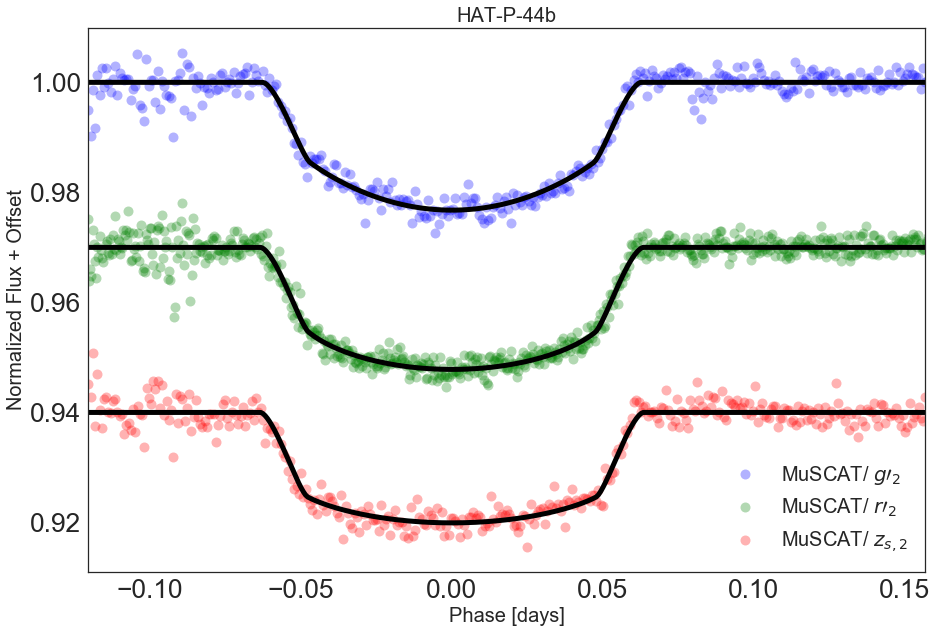

In [105]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

final_df=pd.read_csv('after_mcmc_corot5b.csv', parse_dates=True, index_col=0)

tc=pv[3]
final_df.index=final_df.index-tc
fig,ax=pl.subplots(1,1,figsize=(15,10))
cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.03
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('HAT-P-44b', fontsize=fontsize)
ax.legend(labels,loc='best', fontsize=fontsize)

In [106]:
fig.savefig('figs/grz.png')

## Best fit models and (binned) residuals
* binning3 function is not implemented because of NaNs; df.resample is better because it takes into account the actual time and not only the separation between data points (e.g. two consecutive data points might be NaN and it can be problematic after binning). 
* See `width` to check binning width in min

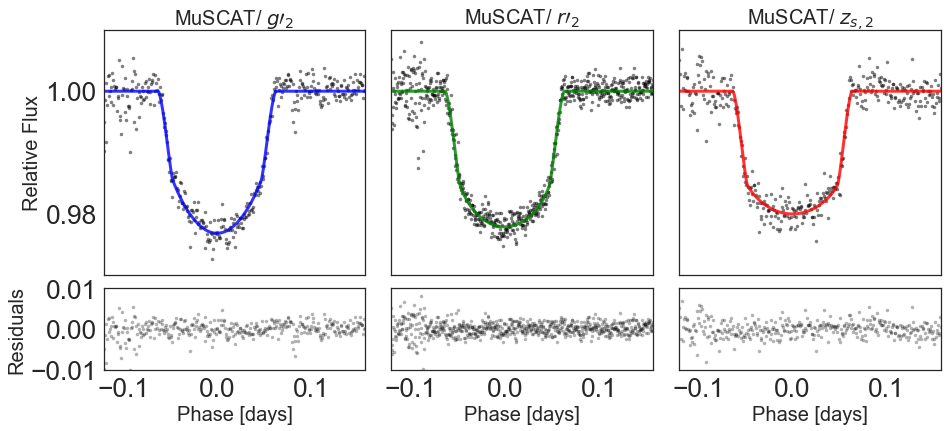

In [107]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 3})
from scipy import stats

final_df=pd.read_csv('after_mcmc_corot5b.csv', parse_dates=True, index_col=0)
#final_df = df.set_index(pd.to_datetime(df.index, unit='D', origin=offset))

from matplotlib import gridspec

fig = pl.figure(figsize=(15,8))

gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[3, 1, 1],
                       wspace=0.1, 
                       hspace=0.1
                       )
clip=False
binn=False
clipped=20
binning='3T'
ylims= [0.97,1.01]
ylims2= [-0.01,0.01]

tc=pv[3]
final_df.index=final_df.index-tc

ax1 = pl.subplot(gs[0])
if clip==True:
    final_df.iloc[:-clipped]['g(f-sys)'].plot(marker='.',alpha=0.5, 
                                            linestyle='', color='k', ax=ax1)
elif binn==True:
    final_df['g(f-sys)'].resample(binning).mean().plot(marker='.', 
                                alpha=0.1, linestyle='-', color=colors[0], ax=ax1)
else:
    final_df['g(f-sys)'].plot(marker='.', 
                                alpha=0.5, linestyle='', color='k', ax=ax1)
final_df['g_mod'].plot(linestyle='-',alpha=0.8, color=colors[0], ax=ax1)

ax1.set_ylim(ylims)
ax1.set_title(r'MuSCAT/ $g\prime_2$',fontsize=fontsize)
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux',fontsize=fontsize)
ax1.set_xlabel('')

ax2 = pl.subplot(gs[1])

if clip==True:
    final_df.iloc[:-clipped]['r(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[1], ax=ax2)
elif binn==True:
    final_df['r(f-sys)'].resample(binning).mean().plot(
        marker='.', alpha=0.1, linestyle='-', color=colors[1], ax=ax2)
else:
    final_df['r(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax2)
final_df['r_mod'].plot(alpha=0.8, linestyle='-', color=colors[1], ax=ax2)

ax2.set_ylim(ylims)
ax2.set_title(r'MuSCAT/ $r\prime_2$',fontsize=fontsize)
#ax2.axis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('')

ax3 = pl.subplot(gs[2])

if clip==True: #dropna, clip
    final_df.iloc[:-clipped]['z(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[2], ax=ax3)
elif binn==True: #bin
    final_df['z(f-sys)'].resample(binning).mean().plot(
        marker='.', ls='', alpha=0.1, linestyle='-', color=colors[2], ax=ax3)
else:
    final_df['z(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax3)
final_df['z_mod'].plot(linestyle='-', alpha=0.8, color=colors[2], ax=ax3)
    
ax3.set_ylim(ylims)
ax3.set_title(r'MuSCAT/ $z_{s,2}$',fontsize=fontsize)
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.set_yticklabels([])

ax4 = pl.subplot(gs[3])
diff_g=final_df['g(f-sys)']-final_df['g_mod']
diff_g.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax4)
#diff_g.resample(binning).mean().plot(marker='.', ax=ax4)

# t_bin=binning3(ts[0],bins=n_min_binning['g'])
# res_bin=binning3(diff_g.values,bins=n_min_binning['g'])
# ax4.plot(t_bin,res_bin,'bo')
ax4.set_ylabel('Residuals',fontsize=fontsize)
ax4.set_ylim(ylims2)
#ax4.set_xticklabels([])
ax4.set_xlabel('Phase [days]',fontsize=fontsize)

ax5 = pl.subplot(gs[4])
diff_r=final_df['r(f-sys)']-final_df['r_mod']
diff_r.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax5)
#diff_r.resample(binning).mean().plot(marker='.', ax=ax5)

# t_bin=binning3(ts[1],bins=n_min_binning['r'])
# res_bin=binning3(diff_r.values,bins=n_min_binning['r'])
# ax5.plot(t_bin,res_bin,'go')
ax5.set_ylim(ylims2)
#ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xlabel('Phase [days]',fontsize=fontsize)

ax6 = pl.subplot(gs[5])
diff_z=final_df['z(f-sys)']-final_df['z_mod']
diff_z.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax6)
#fit
slope, intercept, r_value, p_value, std_err = stats.linregress(diff_z.index-tc,diff_z)
y=slope*diff_z.index-tc+intercept
ax6.plot(diff_z.index,y,alpha=0.8, linestyle='-', color=colors[2])
#diff_z.resample(binning).mean().plot(marker='.', ax=ax6)

# t_bin=binning3(ts[2],bins=n_min_binning['z'])
# res_bin=binning3(diff_z.values,bins=n_min_binning['z'])
# ax6.plot(t_bin,res_bin,'bo')
ax6.set_ylim(ylims2)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xlabel('Phase [days]',fontsize=fontsize)

In [108]:
fig.savefig('figs/grz with rms.png')

## Comparison of k

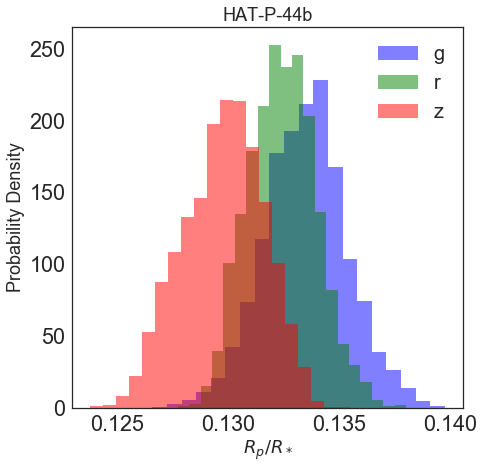

In [109]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

k_samples=[]
fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-44b',fontsize=18)
pl.legend(fontsize=fontsize)

In [110]:
fig.savefig('figs/radius ratios.png')

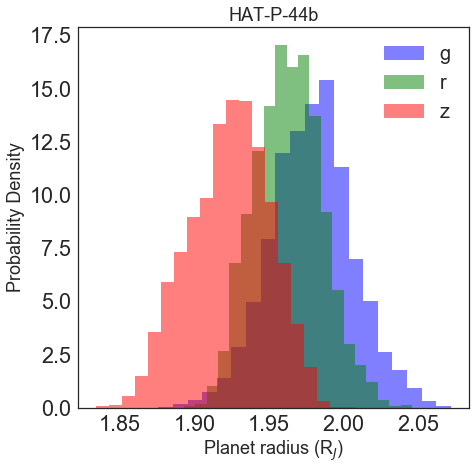

In [112]:
from astropy import units as u

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

Rs=Rp.nominal_value #*u.Rsun.to(u.Rjup) #± 0.04

k_samples=[]
fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    factor=Rs*u.Rsun.to(u.Rjup)
    ax.hist(sampled*factor,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'Planet radius (R$_J$)',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-44b',fontsize=18)
pl.legend(fontsize=fontsize)

In [113]:
fig.savefig('figs/radius ratios Rjup.png')

In [87]:
sigma_g_minus,sigma_g_mean,sigma_g_plus= np.percentile(k_samples[0],[15.9,50,84.1])
sigma_z_minus,sigma_z_mean,sigma_z_plus= np.percentile(k_samples[2],[15.9,50,84.1])
#diff=sigma_g_mean-sigma_z_mean
diff=sigma_g_minus-sigma_z_plus

sig=np.sqrt(sigma_z_plus**2+sigma_g_minus**2)
print('sigma_rss={}'.format(sig))
print('diff={}'.format(diff))
print('sigma={}'.format(diff/sig))

sigma_rss=0.16335996704117076
diff=0.007557338334179611
sigma=0.04626187474851152


In units of Jupiter radius

## transmission spectrum

* See also procedure of [Nikolov+2016](https://arxiv.org/pdf/1610.01186.pdf)

In [74]:
for n in range(3):
    print(np.percentile(fc[::10,n],[50,16,84]))

[ 0.12474601  0.11925188  0.1303077 ]
[ 0.11978158  0.11510211  0.12453312]
[ 0.10596946  0.10027771  0.11165235]


In [75]:
pv[:3]

array([ 0.11901455,  0.12429726,  0.10195079])

* blue (g'2 : 400-550nm)
* red (r'2 : 550-700nm)
* NIR (zs,2 : 820-920nm)
* rp/rs=0.1343 (i-band)

slope=-0.000007


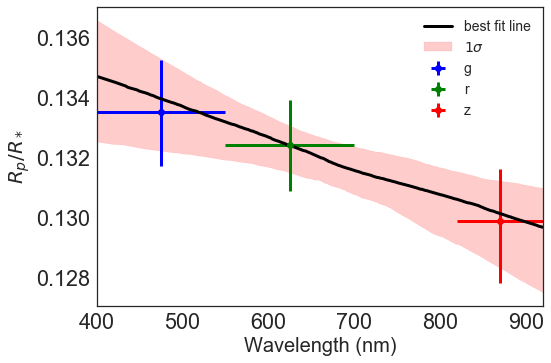

In [114]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

#bandwidths
xs1=[400,550,820]
xs2=[550,700,920]
#mean of each band
xmean=np.mean([xs1,xs2],axis=0)
ys=[]

#plot max aposteriori
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84],axis=0)
    ys.append(y)
    
#fit a line to k1,k2,k3
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
#ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'k-')

#sample and fit slopes and intercepts from the posterior
n = 10000
x = xmean
xi = np.linspace(400, 920, 500)
ys = []
lines = []
for i in range(n):
    y = fc[i,:3]
    slope,intercept,rvalue,pvalue,stderr = lg(xmean,y)
    line = slope * xi + intercept
    lines.append(line)
    
lo, hi, mid = np.percentile(lines, [16, 84, 50], axis=0)
ax.fill_between(xi, lo, hi, color='r', alpha=0.2, label='$1\sigma$')
ax.plot(xi,mid,'k-',label='best fit line')

# plot each sample
# for slop,interc in zip(slopes,intercepts):
#     ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)

#
bands='g,r,z'.split(',')
new_axis=[]
for n,(x,c,b) in enumerate(zip(xmean,colors,bands)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c, label=b) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)
ax.set_xlim(400,920)
ax.legend(fontsize=14)

print('slope={:.6f}'.format(slope))

In [115]:
fig.savefig('figs/spectrum.png')

slope=-0.000048


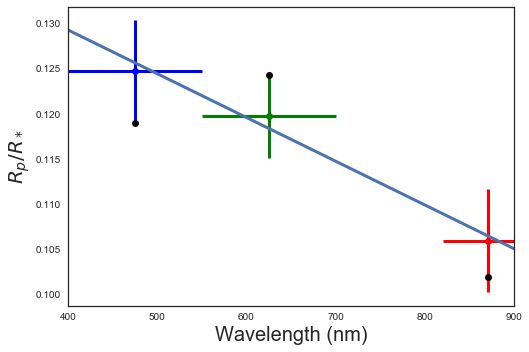

In [68]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820] #lower bandwidth
xs2=[550,700,920] #upper bandwidth
xmean=np.mean([xs1,xs2],axis=0)

Rs=1.186

ys=[]
new_axis=[]

colors='b,g,r'.split(',')
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c)    
    new_axis.append(y*Rs)
    
#add i-band measurement
#ax.errorbar(763,0.1344,yerr=0.0011,fmt='o',color='orange')

#Na absorption line
#ax.axvline(x=590, ymin=0,ymax=1, linestyle='--', color='k')
#K absorption line
#ax.axvline(x=770, ymin=0,ymax=1, linestyle='--', color='k')


# ax2 = ax.twinx() # now, ax2 is responsible for "top" axis and "right" axis
# ax2.set_xticks(new_axis)
# ax2.set_xlabel('R_p (R_${Jup}$)')

ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept)
ax.set_xlim(400,900)
print('slope={:.6f}'.format(slope))

In [94]:
slopes=[]
intercepts=[]
nsamples=1000

s1=k_samples[0][np.random.randint(0, k_samples[0].shape[0], size=nsamples)]
s2=k_samples[1][np.random.randint(0, k_samples[1].shape[0], size=nsamples)]
s3=k_samples[2][np.random.randint(0, k_samples[2].shape[0], size=nsamples)]

for ss1,ss2,ss3 in zip(s1,s2,s3): 
    slope,intercept,_,_,_=lg(xmean,[ss1,ss2,ss3])
    slopes.append(slope)
    intercepts.append(intercept)

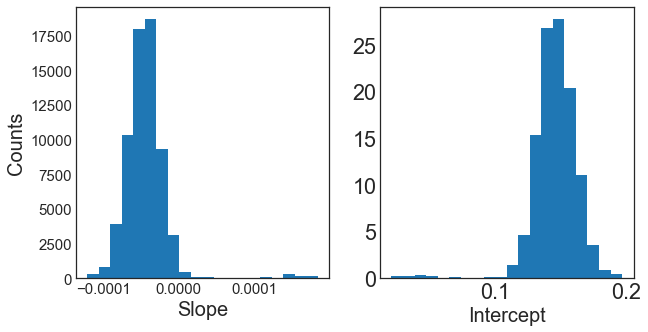

In [96]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
ax[0].hist(slopes,bins=20,normed=True);
ax[0].set_ylabel('Counts',fontsize=fontsize)
ax[0].set_xlabel('Slope',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].hist(intercepts,bins=20,normed=True);
ax[1].set_xlabel('Intercept',fontsize=fontsize)

From the posterior distribution of radius ratios, we took 1000 random samples each and computed the slope of the transmission spectrum (positioned at the center of the broadband filters). The histogram of the slope is shown in Fig. X consistent with negative values with 2.3 sigma.

## significance of detection

In [97]:
x1,x2,x3=np.percentile(slopes,[50,15.9,84.1])
sig_plus=x3-x1
print((0-x1)/sig_plus)

2.36224540668


slope=-0.000047


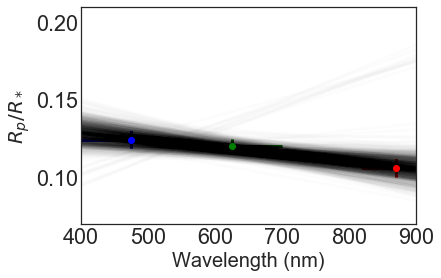

In [98]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820]
xs2=[550,700,920]
xmean=np.mean([xs1,xs2],axis=0)
Rs=0.979
ys=[]

fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'c-')

#slopes and intercepts from the posterior
for slop,interc in zip(slopes,intercepts):
    ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)
ax.set_xlim(400,900)

for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

print('slope={:.6f}'.format(slope))

In [99]:
(pv[0]-pv[1])*Rs

0.0054752030131013322

slope=-0.000047


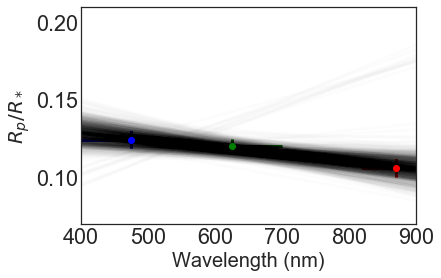

In [100]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820]
xs2=[550,700,920]
xmean=np.mean([xs1,xs2],axis=0)
Rs=1.186
ys=[]

fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'c-')

#slopes and intercepts from the posterior
for slop,interc in zip(slopes,intercepts):
    ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)
ax.set_xlim(400,900)

for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

print('slope={:.6f}'.format(slope))